<div style="text-align: center; font-size: 40px; color: #3498db; font-weight: bold;">
    IS6061 : Python for Business Analytics
</div>

<div style="font-size: 20px; font-weight: normal; margin-top: 20px;">
    <div style="margin-top: 8px;">
        Vaishnavi Deshmukh (124112412) <br>
    </div>
</div>

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
    Introduction
</div>

### The data analytics lifecycle transforms raw data into actionable insights (wearemci, 2024). This project uses two waste management datasets to analyze quarterly waste distributions, treatment methods, and pricing trends across counties. Before combining the datasets, we identified the need for data cleaning to address inconsistencies and standardize formats. To achieve this, we are defining Python functions for efficient preprocessing. This report outlines our approach, including code quality, data processing, exploratory analysis, and clear documentation, ensuring insights are accurate and actionable.

#### This block imports the required libraries for data manipulation, datetime operations, regular expressions, numerical computations, data visualization, and machine learning functionalities.

In [493]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.exceptions import ConvergenceWarning

#### A utility function to clean and standardize quarter formats to YYYY_Q#, accommodating various date styles and edge cases.

In [496]:
def standardize_quarter(value):
    try:
        # If value is NaN or None, return as is
        if pd.isna(value):
            return value
        
        # Convert to string and remove leading/trailing spaces
        value = str(value).strip()
        
        # First try to parse as pandas datetime
        try:
            date = pd.to_datetime(value)
            quarter = (date.month - 1) // 3 + 1
            return f"{date.year}_Q{quarter}"
        except:
            pass
        
        # If the value contains '/' or '-'
        if '/' in value or '-' in value:
            try:
                # Try multiple date parsing formats
                date_formats = [
                    '%m/%d/%y', '%m/%d/%Y',  # 1/1/04, 1/1/2004
                    '%d-%b-%y', '%d-%b-%Y',  # 1-Jan-04, 1-Jan-2004
                    '%Y-%m-%d',              # 2004-01-01
                    '%d/%m/%Y', '%d-%m-%Y'   # 01/01/2004, 01-01-2004
                ]
                
                for date_format in date_formats:
                    try:
                        date = datetime.strptime(value, date_format)
                        quarter = (date.month - 1) // 3 + 1
                        year = date.year if date.year > 1900 else date.year + 2000
                        return f"{year}_Q{quarter}"
                    except ValueError:
                        continue
            except:
                pass
        
        # Handle written month formats (e.g., "October 01, 2022" or "01 October 2022")
        try:
            value = value.replace(',', '')
            date = pd.to_datetime(value)
            quarter = (date.month - 1) // 3 + 1
            return f"{date.year}_Q{quarter}"
        except:
            pass
        
        # Remove spaces and convert to uppercase for other format processing
        cleaned_value = value.replace(' ', '').upper()
        
        # Handle format: 2004Q1
        if len(cleaned_value) == 6 and cleaned_value[4] == 'Q' and cleaned_value[5].isdigit():
            year = cleaned_value[:4]
            quarter = cleaned_value[5]
            return f"{year}_Q{quarter}"
        
        # Handle format: Q12004
        elif cleaned_value.startswith('Q') and cleaned_value[1].isdigit():
            quarter = cleaned_value[1]
            year = cleaned_value[-4:]
            return f"{year}_Q{quarter}"
        
        # Handle other formats
        else:
            cleaned = ''.join(c if c.isdigit() or c == 'Q' else ' ' for c in value)
            parts = [p for p in cleaned.split() if p]
            
            if not parts:
                return None
            
            years = [p for p in parts if len(p) == 4 and p.isdigit()]
            if not years:
                return None
            year = years[0]
            
            if 'Q' in value.upper():
                quarter_parts = [p for p in value.upper().replace(' ', '').split('Q') if p]
                if len(quarter_parts) > 1 and quarter_parts[1][0].isdigit():
                    quarter = quarter_parts[1][0]
                else:
                    quarter = quarter_parts[0][0]
            else:
                try:
                    date = pd.to_datetime(value)
                    quarter = (date.month - 1) // 3 + 1
                except:
                    return None
            
            return f"{year}_Q{quarter}"
            
    except Exception as e:
        return None

#### Cleans and formats county names by removing redundant terms such as "county" and "co." and ensuring proper capitalization.

In [499]:
def standardize_county(value):
    try:
        # Return None if value is missing
        if pd.isna(value):
            return None

        # Convert to string and lowercase
        value = str(value).lower().strip()

        # Remove variations of 'county' and 'co.'
        patterns = [
            r'\bcounty\b',
            r'\bco\.\b',
            r'\bco\b'
        ]

        # Apply each pattern
        for pattern in patterns:
            value = re.sub(pattern, '', value, flags=re.IGNORECASE)

        # Remove multiple spaces and trim
        value = ' '.join(value.split())

        # Capitalize the first letter of each word
        value = value.title()

        # Remove any remaining punctuation and extra spaces
        value = re.sub(r'[^\w\s]', '', value)
        value = value.strip()

        return value

    except Exception as e:
        return None

#### Matches waste categories to predefined standard labels by normalizing text input and comparing against known variations.

In [502]:
def standardize_waste_category(value):
    try:
        # Handle missing values, NaN, and variations of 'nan'
        if pd.isna(value) or not value or re.match(r'^n\.?a\.?n\.?$', str(value).strip().lower()):
            return None
            
        # Convert to string and remove leading/trailing spaces
        value = str(value).strip()
        
        # Function to clean and normalize text
        def normalize_text(text):
            # First, handle cases where letters are spaced out
            # This will convert "A g r i c u l t u r a l" to "agricultural"
            # Updated pattern to better handle trailing spaces
            spaced_out = re.match(r'^([A-Za-z](\s+[A-Za-z])*)\s*$', text.strip())
            if spaced_out:
                text = ''.join(text.split())
                
            # Remove dots between letters (but preserve spaces)
            text = re.sub(r'\.(?=[a-zA-Z])|(?<=[a-zA-Z])\.', '', text)
            # Replace underscores and hyphens with spaces
            text = text.replace('_', ' ').replace('-', ' ')
            # Normalize multiple spaces
            text = re.sub(r'\s+', ' ', text)
            return text.strip()
            
        # Split the input into words and normalize each word separately
        # Updated to handle multiple spaces between words
        words = [w for w in re.split(r'\s+', value.strip()) if w]
        normalized_words = [normalize_text(word) for word in words]
        value = ' '.join(normalized_words)
        
        # Define standard categories and their variations
        waste_categories = {
            'Chemical Waste': [
                'chemical waste',
                'waste chemical',
                'chemicalwaste',
                'chemicals',
                'c h e m i c a l w a s t e',
                'C h e m i c a l  W a s t e',
                'C h e m i c a l  W a s t e '
            ],
            'Electronic Waste': [
                'electronic waste',
                'e waste',
                'ewaste',
                'electronic waste (e-waste)',
                'e-waste',
                'waste electronic',
                'waste (e-waste) electronic',
                'electronic (e-waste) waste',
                'E l e c t r o n i c  W a s t e ',
                'E L E C T R O N I C W A S T E (e W A S T E )'
            ],
            'Medical Waste': [
                'medical waste',
                'waste medical',
                'medicalwaste',
                'm e d i c a l w a s t e',
                'M e d i c a l  W a s t e '
            ],
            'Agricultural Waste': [
                'agricultural waste',
                'waste agricultural',
                'agriculturalwaste',
                'a g r i c u l t u r a l w a s t e',
                'A g r i c u l t u r a l  W a s t e '
            ],
            'Industrial Hazardous Waste': [
                'industrial hazardous waste',
                'hazardous waste industrial',
                'industrial waste hazardous',
                'hazardous industrial waste',
                'industrialhazardouswaste',
                'I n d u s t r i a l  H a z a r d o u s  W a s t e '
            ],
            'Industrial Non-Hazardous Waste': [
                'industrial non hazardous waste',
                'non hazardous industrial waste',
                'industrial waste non hazardous',
                'waste non hazardous industrial',
                'non-hazardous waste industrial',
                'waste industrial non hazardous',
                'I n d u s t r i a l  N o n  H a z a r d o u s  W a s t e '
            ],
            'Municipal Solid Waste': [
                'municipal solid waste',
                'solid municipal waste',
                'municipal waste solid',
                'municipalsolidwaste',
                'm u n i c i p a l s o l i d w a s t e',
                'M u n i c i p a l  S o l i d  W a s t e '
            ],
            'Construction and Demolition Waste': [
                'construction and demolition waste',
                'demolition and construction waste',
                'construction waste and demolition',
                'and waste demolition construction',
                'construction waste',
                'demolition waste',
                'constructionanddemolitionwaste',
                'C o n s t r u c t i o n  a n d  D e m o l i t i o n  W a s t e '
            ],
            'Organic Waste': [
                'organic waste',
                'waste organic',
                'organicwaste',
                'o r g a n i c w a s t e',
                'O r g a n i c  W a s t e '
            ]
        }
        
        # Function to normalize for comparison
        def normalize_for_comparison(text):
            # Remove all spaces and convert to lowercase
            return ''.join(text.lower().strip().split())
        
        # Normalize the input value for comparison
        normalized_input = normalize_for_comparison(value)
        
        # First, try exact matches (after normalization)
        for standard_category, variations in waste_categories.items():
            normalized_variations = [normalize_for_comparison(var) for var in variations]
            normalized_standard = normalize_for_comparison(standard_category)
            
            if normalized_input in normalized_variations or normalized_input == normalized_standard:
                return standard_category
        
        # Then try partial matches
        for standard_category, variations in waste_categories.items():
            category_words = set(standard_category.lower().split())
            value_words = set(value.lower().split())
            
            if category_words.issubset(value_words) or category_words.issuperset(value_words):
                return standard_category
        
        # If no match found, return properly capitalized value
        return ' '.join(word.capitalize() for word in value.lower().split())
        
    except Exception as e:
        print(f"Error processing value '{value}': {str(e)}")
        return None

#### Cleans and matches treatment method names to predefined standard formats, ensuring consistent naming across datasets.

In [505]:
def standardize_treatment_method(value):
    try:
        # Handle missing values
        if pd.isna(value) or value == '#NAME?' or not value:
            return None

        # Convert to string and remove leading/trailing spaces
        value = str(value).strip()

        # Function to clean and normalize text
        def normalize_text(text):
            # Remove dots between letters
            text = re.sub(r'\.(?=[a-zA-Z])|(?<=[a-zA-Z])\.', '', text)
            # Replace underscores and multiple spaces with single space
            text = text.replace('_', ' ').replace('-', ' - ')
            # Normalize multiple spaces
            text = re.sub(r'\s+', ' ', text)
            return text.strip()

        # Normalize the text
        value = normalize_text(value)
        
        # Convert to lowercase for comparison
        value_lower = value.lower()

        # Dictionary of standard categories and their variations
        treatment_methods = {
            'Disposal - Incineration': [
                'disposal incineration',
                'disposal - incineration',
                'incineration disposal',
                'incineration - disposal',
                'd i s p o s a l i n c i n e r a t i o n'
            ],
            'Disposal - Landfill': [
                'disposal landfill',
                'disposal - landfill',
                'landfill disposal',
                'landfill - disposal',
                'd i s p o s a l l a n d f i l l'
            ],
            'Disposal - Other': [
                'disposal other',
                'disposal - other',
                'other disposal',
                'other - disposal',
                'd i s p o s a l o t h e r'
            ],
            'Recovery - Recycling': [
                'recovery recycling',
                'recovery - recycling',
                'recycling recovery',
                'recycling - recovery',
                'r e c o v e r y r e c y c l i n g'
            ],
            'Recovery - Composting': [
                'recovery composting',
                'recovery - composting',
                'composting recovery',
                'composting - recovery',
                'r e c o v e r y c o m p o s t i n g'
            ],
            'Recovery - Energy Recovery': [
                'recovery energy recovery',
                'recovery - energy recovery',
                'energy recovery recovery',
                'energy recovery - recovery',
                'r e c o v e r y e n e r g y r e c o v e r y'
            ]
        }

        # Remove all spaces and convert to lowercase for comparison
        value_normalized = ''.join(value_lower.split())

        # First try exact matches
        for standard, variations in treatment_methods.items():
            variations_normalized = [''.join(var.lower().split()) for var in variations]
            if value_normalized in variations_normalized:
                return standard

        # If no exact match found, try fuzzy matching
        for standard, variations in treatment_methods.items():
            # Check if all the key words are present
            standard_words = set(standard.lower().split(' - '))
            value_words = set(value_lower.split())
            
            # Check if the main category words are present
            if all(word in value_normalized for word in standard_words):
                return standard

        # If no match found, try to construct from parts
        if 'disposal' in value_lower:
            if 'incineration' in value_lower:
                return 'Disposal - Incineration'
            elif 'landfill' in value_lower:
                return 'Disposal - Landfill'
            elif 'other' in value_lower:
                return 'Disposal - Other'
        elif 'recovery' in value_lower:
            if 'recycling' in value_lower:
                return 'Recovery - Recycling'
            elif 'composting' in value_lower:
                return 'Recovery - Composting'
            elif 'energy' in value_lower:
                return 'Recovery - Energy Recovery'

        # If still no match found, return None
        return None

    except Exception as e:
        print(f"Error processing value '{value}': {str(e)}")
        return None

#### Extracts numeric values from strings, handles decimal points, and rounds to two decimal places for consistent formatting.

In [508]:
def standardize_numeric_values(value):
    if pd.isna(value):
        return None
    
    # Convert to string if not already
    value = str(value)
    
    # Initialize empty string for numbers
    number_str = ''
    decimal_count = 0
    
    # Keep only the first occurrence of a valid number
    for char in value:
        if char.isdigit():
            number_str += char
        elif char == '.' and decimal_count == 0 and number_str != '':
            number_str += char
            decimal_count += 1
        elif char == ',' and len(number_str) > 0:
            # Skip commas if they're within a number
            continue
        elif len(number_str) > 0 and char != ',' and char != '.':
            # Stop if we encounter any other character after getting a number
            break
    
    if not number_str:
        return None
    
    # Replace comma with empty string for proper float conversion
    number_str = number_str.replace(',', '')
    
    # Convert to float and round to 2 decimal places
    return round(float(number_str), 2)

#### Reads input CSV files, standardizes key fields, tracks processing success, and saves the cleaned data to new files.

In [511]:
def process_and_save_standardized_data(input_files, output_files):
    try:
        for input_file, output_file in zip(input_files, output_files):
            # Read the CSV file
            df = pd.read_csv(input_file)
            
            # Initialize statistics dictionaries
            stats = {
                'Quarter': {'total': 0, 'success': 0, 'failed': 0},
                'County': {'total': 0, 'success': 0, 'failed': 0},
                'Waste Category': {'total': 0, 'success': 0, 'failed': 0},
                'Treatment Method': {'total': 0, 'success': 0, 'failed': 0},
                'Waste Amount (tonnes)': {'total': 0, 'success': 0, 'failed': 0},
                'Price of Treatment (€ per tonne)': {'total': 0, 'success': 0, 'failed': 0}
            }
            
            # Function to process a column and update statistics
            def process_column(df, column_name, standardize_func):
                if column_name in df.columns:
                    stats[column_name]['total'] = len(df[column_name])
                    
                    def process_value(value):
                        standardized_value = standardize_func(value)
                        if standardized_value is not None:
                            stats[column_name]['success'] += 1
                        else:
                            stats[column_name]['failed'] += 1
                        return standardized_value
                    
                    df[column_name] = df[column_name].apply(process_value)
                return df
            
            # Apply standardization to available columns
            df = process_column(df, 'Quarter', standardize_quarter)
            df = process_column(df, 'County', standardize_county)
            df = process_column(df, 'Waste Category', standardize_waste_category)
            df = process_column(df, 'Treatment Method', standardize_treatment_method)
            df = process_column(df, 'Waste Amount (tonnes)', standardize_numeric_values)
            df = process_column(df, 'Price of Treatment (€ per tonne)', standardize_numeric_values)
            
            # Print statistics for this file
            print(f"\nProcessing results for {input_file}:")
            for column, counts in stats.items():
                if column in df.columns:  # Only show stats for columns that exist in this file
                    print(f"\n--- {column} Column ---")
                    print(f"Total rows processed: {counts['total']}")
                    print(f"Successfully standardized: {counts['success']}")
                    print(f"Failed to standardize: {counts['failed']}")
                    
                    # Print unique values for Waste Category and Treatment Method
                    if column in ['Waste Category', 'Treatment Method']:
                        print(f"\nUnique values in {column}:")
                        unique_values = df[column].drop_duplicates(keep='first')
                        for index, value in unique_values.items():
                            print(f"Value: {value}, Index: {index}")
            
            # Save the cleaned DataFrame
            df.to_csv(output_file, index=False)
            print(f"\nData has been processed and saved to {output_file}")
            
    except Exception as e:
        logger.error(f"Error during processing: {e}")
        raise

#### Performs missing value imputation for numerical columns using Random Forest regression, ensuring that missing values are replaced with estimated values based on the relationships in the data.

In [514]:
def perform_random_forest_imputation(data, numerical_columns):
    warnings.simplefilter("ignore", ConvergenceWarning)
    
    rf_imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
        max_iter=5,
        tol=1e-3,
        random_state=42,
        initial_strategy='mean'
    )

    # Perform imputation
    numerical_data_imputed = pd.DataFrame(
        rf_imputer.fit_transform(data[numerical_columns]),
        columns=numerical_columns
    )

    # Round to 2 decimal places
    for col in numerical_columns:
        data[col] = numerical_data_imputed[col].round(2)

    return data

#### This function visualizes the distributions of "Waste Amount (tonnes)" and "Price of Treatment (€ per tonne)" using histograms with kernel density estimates to help understand their spread and central tendency.

In [517]:
def plot_waste_and_price_distribution(data):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    
    # Waste Amount (tonnes)
    sns.histplot(data['Waste Amount (tonnes)'].dropna(), kde=True, bins=30, ax=ax[0])
    ax[0].set_title('Distribution of Waste Amount (tonnes)')
    ax[0].set_xlabel('Waste Amount (tonnes)')
    ax[0].set_ylabel('Frequency')
    
    # Price of Treatment (€ per tonne)
    sns.histplot(data['Price of Treatment (€ per tonne)'].dropna(), kde=True, bins=30, ax=ax[1])
    ax[1].set_title('Distribution of Price of Treatment (€ per tonne)')
    ax[1].set_xlabel('Price of Treatment (€ per tonne)')
    ax[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

#### Generates a set of visualizations (histogram, box plot) and basic statistics (mean, median, skewness, kurtosis) for a given column of data, help analyze its distribution and detect outliers.


In [520]:
def plot_stats(df, column_name, stage=""):
    """
    Plot distribution and display statistics for a numerical column with tabular formatting
    """
    print(f"\n{'='*50}")
    print(f"{stage} - Analysis for {column_name}")
    print(f"{'='*50}")
    # Basic Statistics in Tabular Format
    print("\nBasic Statistics:")
    basic_stats = df[column_name].describe()
    # Convert basic statistics to a DataFrame for tabular display
    basic_stats_table = pd.DataFrame(basic_stats).reset_index()
    basic_stats_table.columns = ['Statistic', 'Value']
    print(tabulate(basic_stats_table, headers='keys', tablefmt='pretty', showindex=False))
    # Additional Statistics in Tabular Format
    additional_stats = [
        ['Metric', 'Value'],
        ['Missing Values', df[column_name].isnull().sum()],
        ['Skewness', f"{df[column_name].skew():.2f}"],
        ['Kurtosis', f"{df[column_name].kurtosis():.2f}"]
    ]
    print("\nAdditional Statistics:")
    print(tabulate(additional_stats[1:], headers=additional_stats[0], tablefmt='pipe'))
    # Create subplot with histogram and box plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    # Histogram with KDE
    sns.histplot(data=df[column_name].dropna(), kde=True, bins=30, ax=ax1)
    ax1.set_title(f'Histogram of {column_name} - {stage}')
    ax1.set_xlabel(column_name)
    ax1.set_ylabel('Count')
    # Box plot
    sns.boxplot(x=df[column_name].dropna(), ax=ax2)
    ax2.set_title(f'Box Plot of {column_name} - {stage}')
    ax2.set_xlabel(column_name)
    plt.tight_layout()
    plt.show()

#### Detects outliers in the data using the Interquartile Range (IQR) method and offers two methods to handle them: imputing (replacing with NaN for later imputation) or removing the outliers.

In [523]:
def handle_outliers(df, column_name, method='impute'):
    # Calculate Q1, Q3, and IQR
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"\nOutlier Thresholds for {column_name}:")
    print(f"Lower bound: {lower_bound:.2f}")
    print(f"Upper bound: {upper_bound:.2f}")
    
    # Create mask for outliers
    outlier_mask = (df[column_name] < lower_bound) | (df[column_name] > upper_bound)
    outlier_count = outlier_mask.sum()
    print(f"Number of outliers detected: {outlier_count}")
    
    if method == 'impute':
        # Replace outliers with NaN for later imputation
        df.loc[outlier_mask, column_name] = np.nan
        return df
    else:
        # Remove outliers
        return df[~outlier_mask]

#### Provides a detailed outlier analysis report for a specified column, including statistical boundaries, outlier details, and contextual information such as the number of outliers, their percentiles, and their relationship to the overall dataset.

In [526]:
def detailed_outlier_analysis(data, column_name):
    # Calculate statistical measures
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Identify outliers
    outliers = data[data[column_name] > upper_bound]
    # Detailed outlier analysis
    outlier_analysis = {
        'statistical_summary': {
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        },
        'outlier_details': []
    }
    # Collect detailed information about each outlier
    for _, row in outliers.iterrows():
        outlier_info = {
            'Quarter': row['Quarter'],
            'Total_Cost': row[column_name],
            'Difference_from_upper_bound': row[column_name] - upper_bound,
            'Percentile': (row[column_name] / data[column_name].max()) * 100
        }
        outlier_analysis['outlier_details'].append(outlier_info)
    # Additional context
    outlier_analysis['outlier_context'] = {
        'total_outliers': len(outliers),
        'outlier_percentage': (len(outliers) / len(data)) * 100,
        'max_value': data[column_name].max(),
        'mean': data[column_name].mean(),
        'median': data[column_name].median()
    }
    return outlier_analysis

#### Processes and standardizes data from input files and saves the results in the specified output files.

In [529]:
input_files = [
        'quarterly_waste_treatment.csv',  # First file with all columns
        'quarterly_waste_generation.csv'  # Second file with common columns
    ]
    
output_files = [
    'standardized_output1.csv',
    'standardized_output2.csv'
]

# Process both files
process_and_save_standardized_data(input_files, output_files)


Processing results for quarterly_waste_treatment.csv:

--- Quarter Column ---
Total rows processed: 45864
Successfully standardized: 45864
Failed to standardize: 0

--- County Column ---
Total rows processed: 45864
Successfully standardized: 43573
Failed to standardize: 2291

--- Waste Category Column ---
Total rows processed: 45864
Successfully standardized: 43865
Failed to standardize: 1999

Unique values in Waste Category:
Value: Chemical Waste, Index: 0
Value: Electronic Waste, Index: 2
Value: Industrial Hazardous Waste, Index: 4
Value: Medical Waste, Index: 6
Value: Agricultural Waste, Index: 8
Value: Construction and Demolition Waste, Index: 11
Value: Industrial Non-Hazardous Waste, Index: 13
Value: Municipal Solid Waste, Index: 16
Value: None, Index: 19
Value: Organic Waste, Index: 20
Value: N A N, Index: 78

--- Treatment Method Column ---
Total rows processed: 45864
Successfully standardized: 43615
Failed to standardize: 2249

Unique values in Treatment Method:
Value: Disposa

#### Merges two dataframes on common columns and saves the combined data into a new CSV file.

In [531]:
df1 = pd.read_csv(output_files[0])
df2 = pd.read_csv(output_files[1])

# List the 5 common columns between the two dataframes
common_columns = df1.columns.intersection(df2.columns)

# Merge the dataframes on the common columns
combined_df = pd.merge(df1, df2, on=common_columns.tolist(), how='outer')  # Use 'how' as 'inner', 'outer', 'left', or 'right' as needed

# Save the combined dataframe to a new Excel file
combined_df.to_csv("combined_file.csv", index=False)

#### Loads the combined dataset and prints its initial shape (rows and columns) along with the count of missing values for each column.

In [533]:
data = combined_df
print("\nInitial Dataset Shape:", data.shape)
print("\nInitial Missing Values:")
print(data.isnull().sum())


Initial Dataset Shape: (65430, 7)

Initial Missing Values:
Quarter                              3327
County                               2957
Waste Type                           3312
Waste Category                       2828
Treatment Method                    21813
Waste Amount (tonnes)                3164
Price of Treatment (€ per tonne)    19564
dtype: int64


#### Replaces infinity values with NaN and handles extreme values by setting values beyond the maximum or minimum representable float as NaN.

In [535]:
# Replace infinities with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)
# Replacing variations of 'N A N', 'NaN', 'nan' with actual np.nan
data.replace(to_replace=r'^\s*(N\s*A\s*N|Nan|NAN)\s*$', value=np.nan, regex=True, inplace=True)
# Handle extreme values
max_float = np.finfo(np.float32).max
min_float = np.finfo(np.float32).min
data = data.apply(
    lambda col: col.map(
        lambda x: np.nan if isinstance(x, (int, float)) and (x > max_float or x < min_float) else x
    )
)

#### Defines categorical and numerical columns, applies ordinal encoding to categorical columns.


Initial Data - Analysis for Waste Amount (tonnes)

Basic Statistics:
+-----------+-----------------------+
| Statistic |         Value         |
+-----------+-----------------------+
|   count   |        62220.0        |
|   mean    | 4.316434724663589e+25 |
|    std    | 6.237813212544523e+27 |
|    min    |         198.0         |
|    25%    |       4208.725        |
|    50%    |        7572.08        |
|    75%    |       13280.145       |
|    max    | 9.549549549549548e+29 |
+-----------+-----------------------+

Additional Statistics:
| Metric         |    Value |
|:---------------|---------:|
| Missing Values |  3210    |
| Skewness       |   145.44 |
| Kurtosis       | 21275.2  |


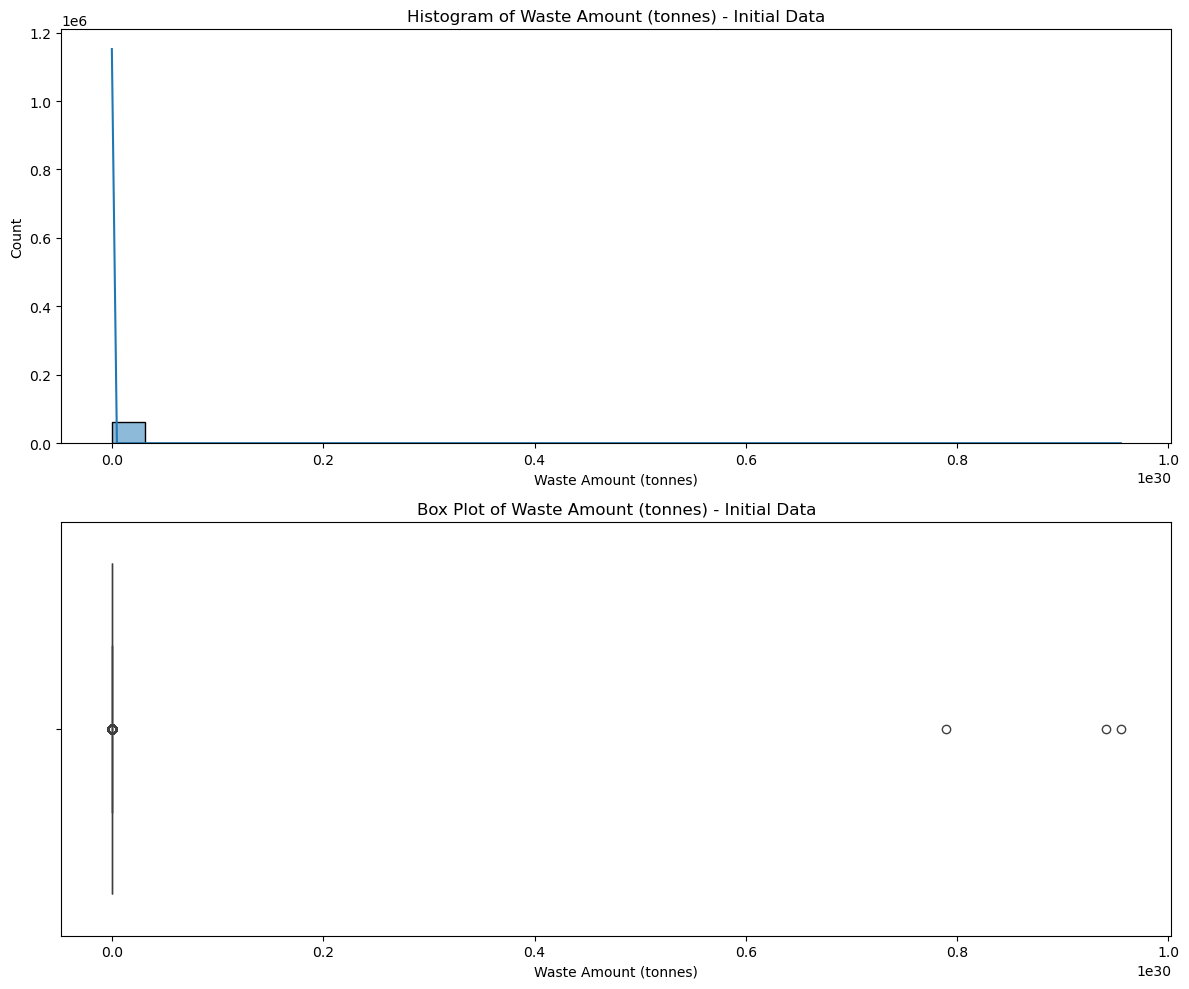


Initial Data - Analysis for Price of Treatment (€ per tonne)

Basic Statistics:
+-----------+-------------------+
| Statistic |       Value       |
+-----------+-------------------+
|   count   |      45866.0      |
|   mean    | 91.55868791697553 |
|    std    | 92.40709273259077 |
|    min    |       20.0        |
|    25%    |       56.0        |
|    50%    |       64.91       |
|    75%    |       74.2        |
|    max    |      599.45       |
+-----------+-------------------+

Additional Statistics:
| Metric         |    Value |
|:---------------|---------:|
| Missing Values | 19564    |
| Skewness       |     3.21 |
| Kurtosis       |     9.87 |


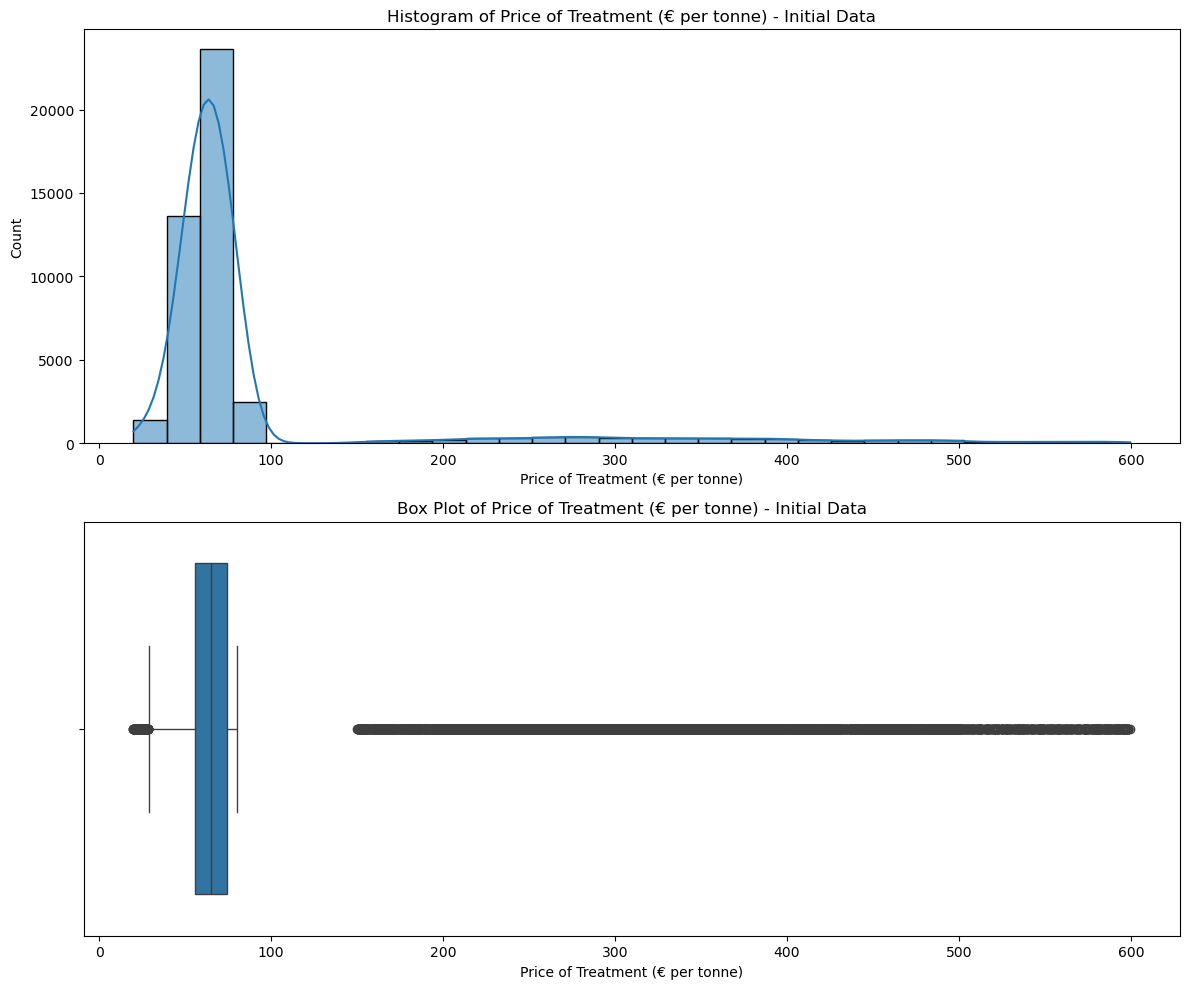


Outlier Thresholds for Waste Amount (tonnes):
Lower bound: -9398.41
Upper bound: 26887.28
Number of outliers detected: 574

After Outlier Handling - Analysis for Waste Amount (tonnes)

Basic Statistics:
+-----------+--------------------+
| Statistic |       Value        |
+-----------+--------------------+
|   count   |      61646.0       |
|   mean    | 8985.885026603512  |
|    std    | 5820.864850419863  |
|    min    |       198.0        |
|    25%    | 4182.200000000001  |
|    50%    |      7489.805      |
|    75%    | 13089.397500000001 |
|    max    |      26857.91      |
+-----------+--------------------+

Additional Statistics:
| Metric         |   Value |
|:---------------|--------:|
| Missing Values | 3784    |
| Skewness       |    0.72 |
| Kurtosis       |   -0.37 |


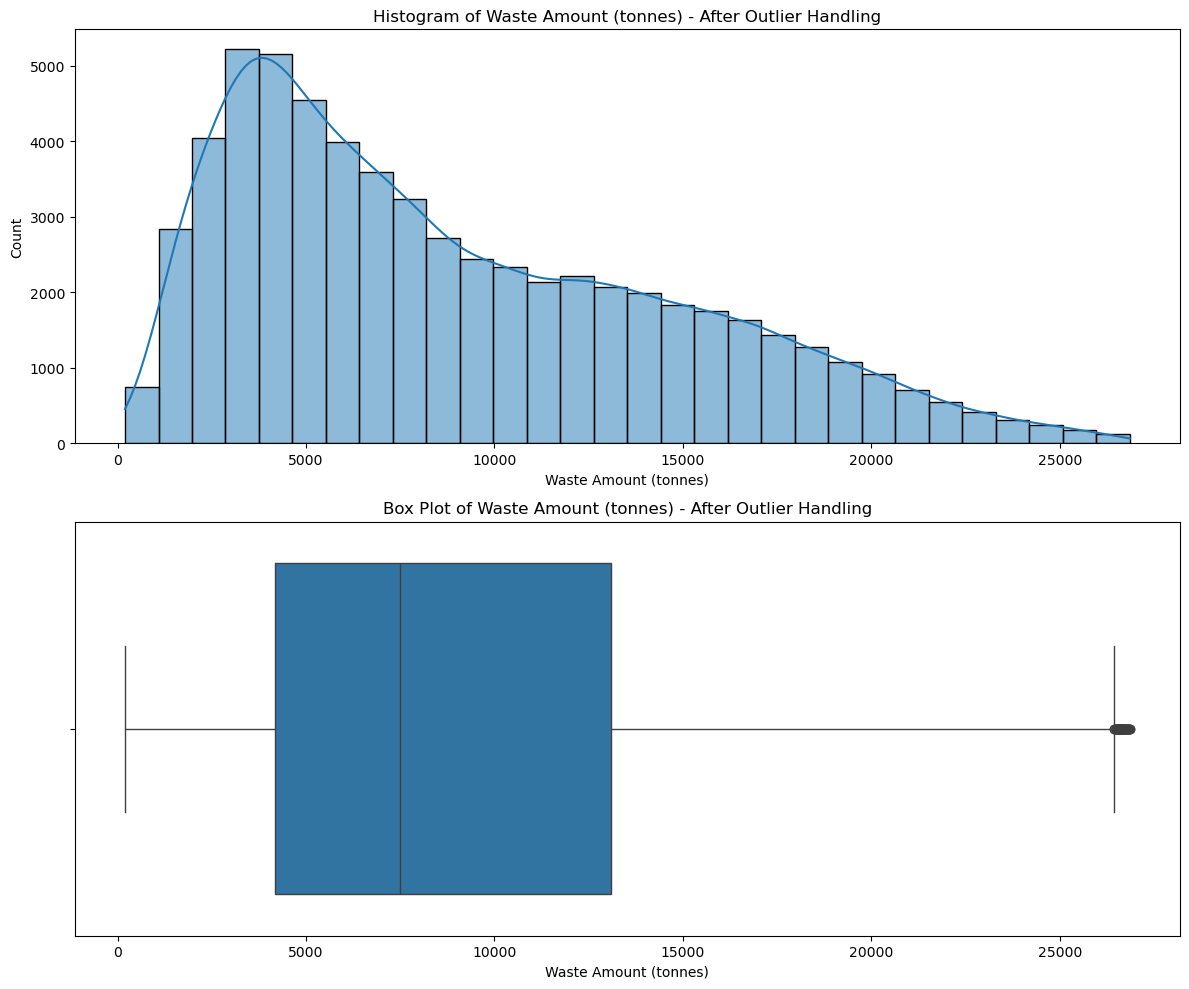


Outlier Thresholds for Price of Treatment (€ per tonne):
Lower bound: 28.70
Upper bound: 101.50
Number of outliers detected: 5149

After Outlier Handling - Analysis for Price of Treatment (€ per tonne)

Basic Statistics:
+-----------+--------------------+
| Statistic |       Value        |
+-----------+--------------------+
|   count   |      40717.0       |
|   mean    | 62.738346636540015 |
|    std    | 10.466567525327678 |
|    min    |       28.73        |
|    25%    |       55.21        |
|    50%    |        63.0        |
|    75%    |       71.17        |
|    max    |        80.0        |
+-----------+--------------------+

Additional Statistics:
| Metric         |    Value |
|:---------------|---------:|
| Missing Values | 24713    |
| Skewness       |    -0.44 |
| Kurtosis       |    -0.11 |


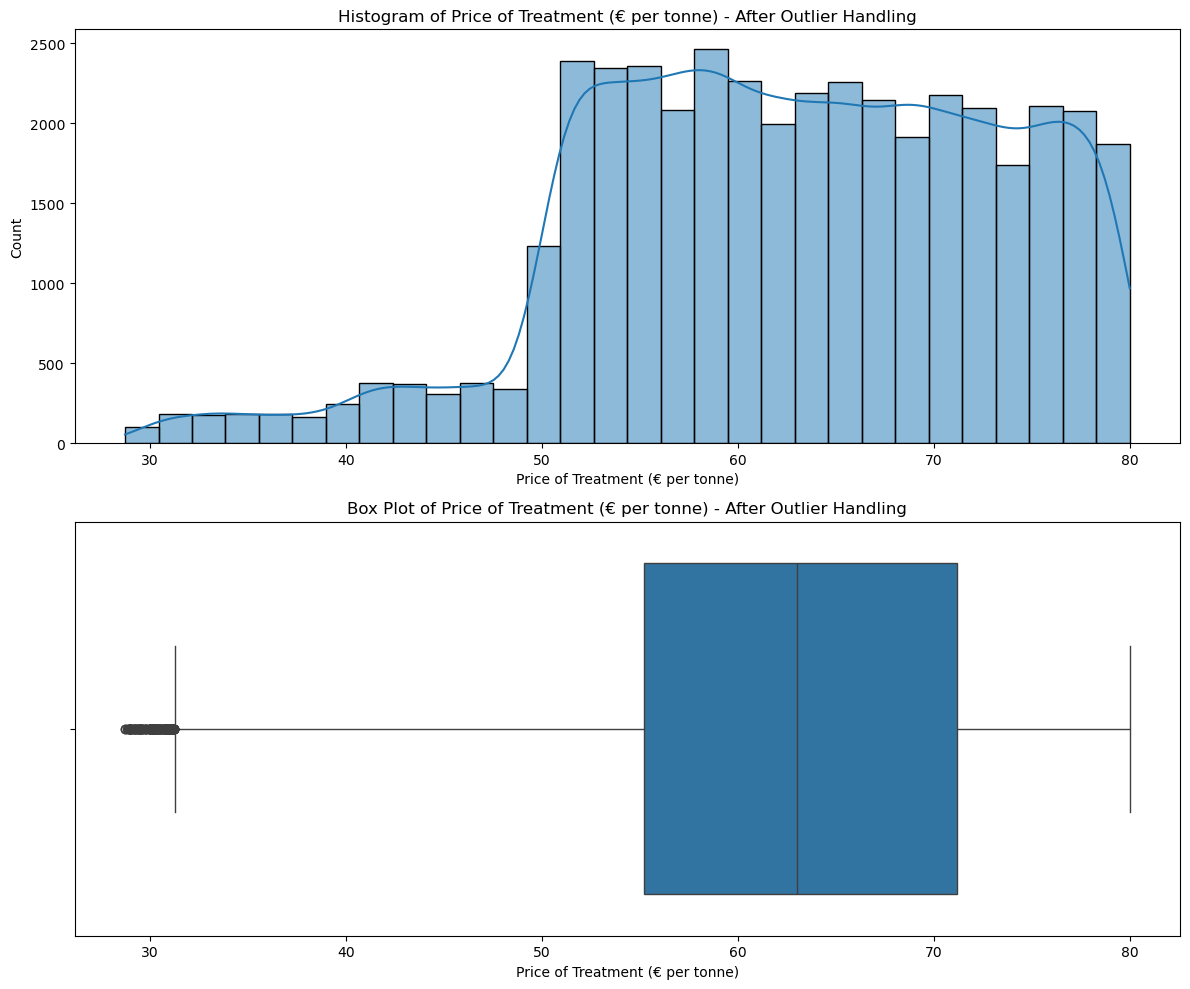


Missing Values After Outlier Handling:
Quarter                              3327
County                               3264
Waste Type                           3312
Waste Category                       3240
Treatment Method                    21813
Waste Amount (tonnes)                3784
Price of Treatment (€ per tonne)    24713
dtype: int64


In [537]:
categorical_columns = ['Quarter', 'County', 'Waste Type', 'Waste Category', 'Treatment Method']
numerical_columns = ['Waste Amount (tonnes)', 'Price of Treatment (€ per tonne)']

# Ordinal encode categorical columns to reduce dimensionality
encoder = OrdinalEncoder()
data[categorical_columns] = encoder.fit_transform(data[categorical_columns])

# Plot initial distributions and statistics
for col in numerical_columns:
    plot_stats(data, col, "Initial Data")

# Handle outliers (replace with NaN instead of removing)
for col in numerical_columns:
    data = handle_outliers(data, col, method='impute')
    plot_stats(data, col, "After Outlier Handling")

print("\nMissing Values After Outlier Handling:")
print(data.isnull().sum())

#### Fills missing values in categorical columns by first using the mode within groups (based on 'Waste Category' and 'Waste Type') and then filling any remaining missing values with the overall mode. Prints the number of missing values before and after filling.

In [539]:
# First pass: Fill categorical values
print("\nFilling Categorical Values...")
for col in categorical_columns:
    if col in data.columns:
        missing_before = data[col].isnull().sum()
        # Fill with mode within groups
        data[col] = data.groupby(['Waste Category', 'Waste Type'])[col].transform(
            lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
        )
        # Fill remaining NaNs with overall mode
        data[col] = data[col].fillna(data[col].mode().iloc[0])
        missing_after = data[col].isnull().sum()
        print(f"\n{col}:")
        print(f"Missing values before: {missing_before}")
        print(f"Missing values after: {missing_after}")



Filling Categorical Values...

Quarter:
Missing values before: 3327
Missing values after: 0

County:
Missing values before: 3264
Missing values after: 0

Waste Type:
Missing values before: 3312
Missing values after: 0

Waste Category:
Missing values before: 3240
Missing values after: 0

Treatment Method:
Missing values before: 21813
Missing values after: 0


#### Performs the second pass of imputation on numerical columns using Random Forest, optimizing the imputation process by reducing iterations and tuning parameters. Replaces original data with the imputed values, rounding them to two decimal places.

In [541]:
# Second pass: Handle numerical values with Random Forest
print("\nPerforming Optimized Random Forest Imputation...")
data = perform_random_forest_imputation(data, numerical_columns)

rf_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),  # Reduce n_estimators for speed
    max_iter=5,  # Lower number of iterations
    tol=1e-3,  # Increase tolerance for early stopping
    random_state=42,
    initial_strategy='mean'
)

# Perform imputation on numerical columns only
numerical_data_imputed = pd.DataFrame(
    rf_imputer.fit_transform(data[numerical_columns]),
    columns=numerical_columns
)

# Replace original data
for col in numerical_columns:
    data[col] = numerical_data_imputed[col].round(2)


Performing Optimized Random Forest Imputation...


<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
    Exploratory Data Analysis (EDA):
</div>


Grouped by Quarter - Analysis for Total Cost of Treatment

Basic Statistics:
+-----------+-------------------+
| Statistic |       Value       |
+-----------+-------------------+
|   count   |       84.0        |
|   mean    | 439568621.2886904 |
|    std    | 490717614.9443617 |
|    min    |    273881025.4    |
|    25%    |   294918634.18    |
|    50%    |   304449267.385   |
|    75%    |  387872035.2275   |
|    max    |   4631290317.38   |
+-----------+-------------------+

Additional Statistics:
| Metric         |   Value |
|:---------------|--------:|
| Missing Values |    0    |
| Skewness       |    7.71 |
| Kurtosis       |   65.87 |


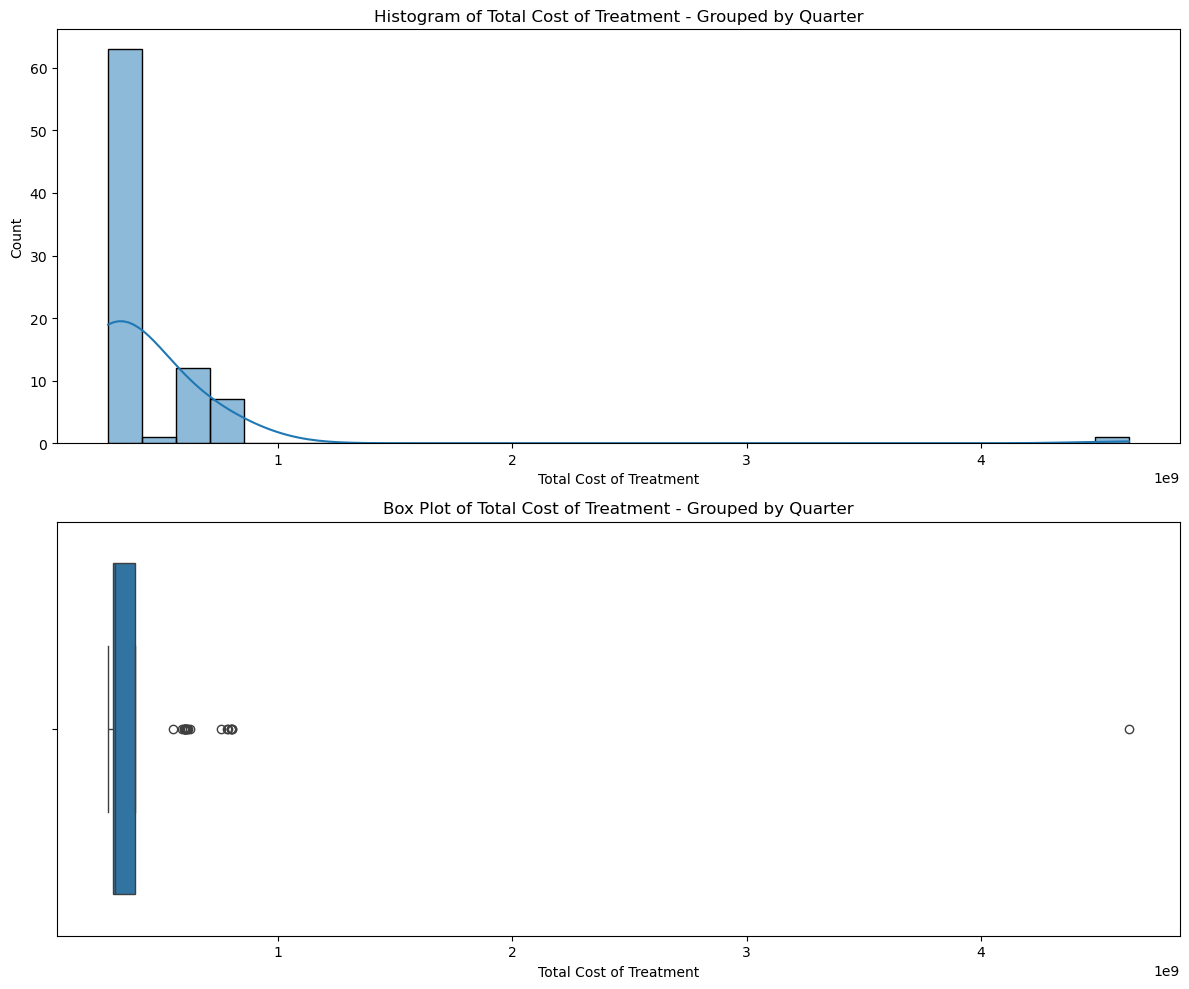


Total Cost of Treatment by Quarter:
    Quarter  Total Cost of Treatment
0       0.0             7.822609e+08
1       1.0             3.040465e+08
2       2.0             3.081608e+08
3       3.0             2.919196e+08
4       4.0             7.997913e+08
..      ...                      ...
79     79.0             3.035562e+08
80     80.0             6.032299e+08
81     81.0             2.942895e+08
82     82.0             3.188984e+08
83     83.0             3.041014e+08

[84 rows x 2 columns]


In [543]:
if 'Total Cost of Treatment' not in data.columns:
    data['Total Cost of Treatment'] = data['Waste Amount (tonnes)'] * data['Price of Treatment (€ per tonne)']

# Round the 'Total Cost of Treatment' column to 2 decimal points
data['Total Cost of Treatment'] = data['Total Cost of Treatment'].round(2)

# Group by quarter and sum the total cost of treatment
total_cost_by_quarter = data.groupby('Quarter')['Total Cost of Treatment'].sum().reset_index()
total_cost_by_quarter['Total Cost of Treatment'] = total_cost_by_quarter['Total Cost of Treatment'].round(2)

# Plot stats for total cost by quarter
plot_stats(total_cost_by_quarter, 'Total Cost of Treatment', "Grouped by Quarter")

print("\nTotal Cost of Treatment by Quarter:")
print(total_cost_by_quarter)

## Plot final distributions and statistics


Final Imputed Data - Analysis for Waste Amount (tonnes)

Basic Statistics:
+-----------+-------------------+
| Statistic |       Value       |
+-----------+-------------------+
|   count   |      65430.0      |
|   mean    | 8933.083638697844 |
|    std    | 5680.129722737575 |
|    min    |       198.0       |
|    25%    |      4336.1       |
|    50%    |     7489.805      |
|    75%    |    12696.9875     |
|    max    |     26857.91      |
+-----------+-------------------+

Additional Statistics:
| Metric         |   Value |
|:---------------|--------:|
| Missing Values |    0    |
| Skewness       |    0.76 |
| Kurtosis       |   -0.23 |


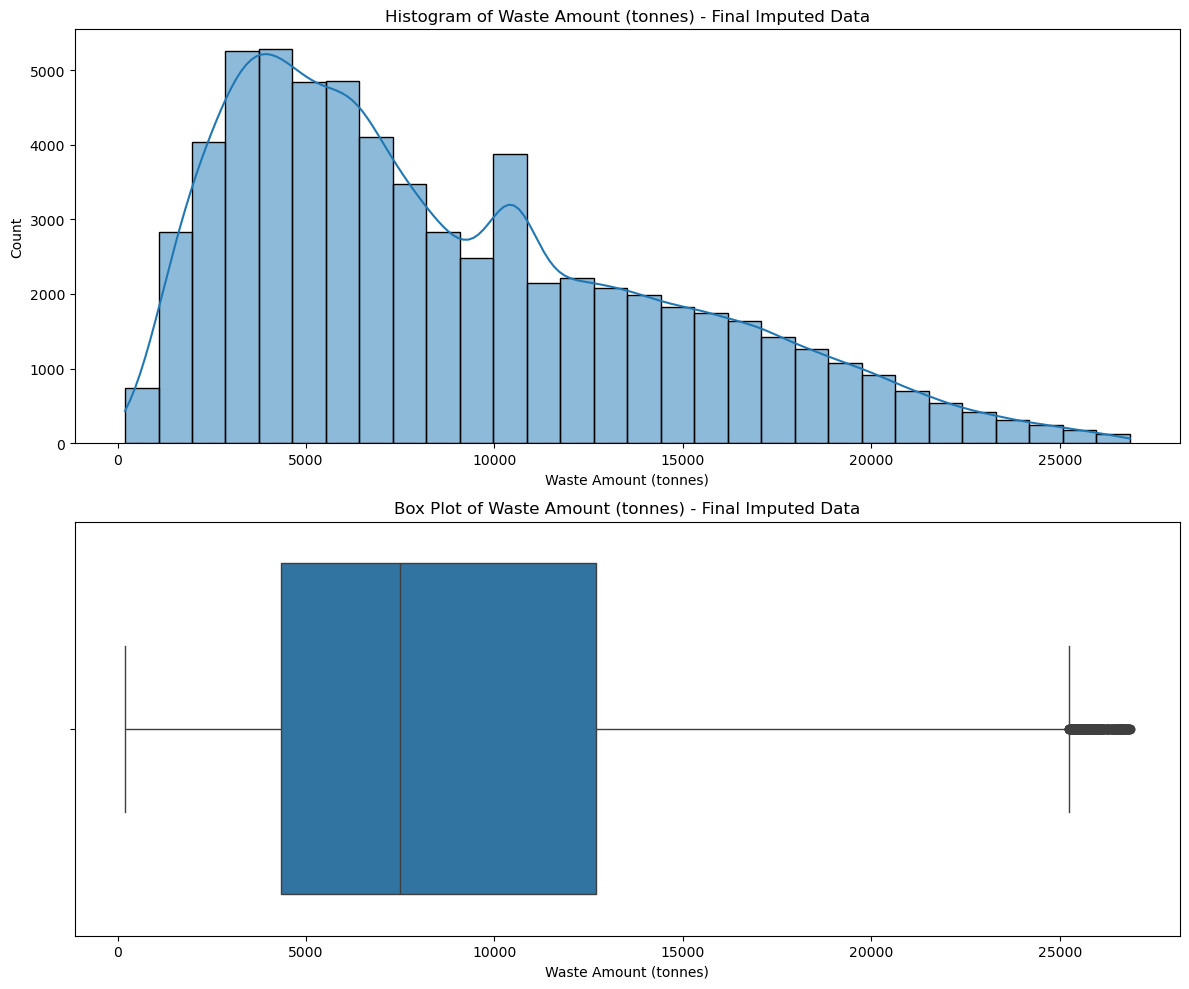


Final Imputed Data - Analysis for Price of Treatment (€ per tonne)

Basic Statistics:
+-----------+--------------------+
| Statistic |       Value        |
+-----------+--------------------+
|   count   |      65430.0       |
|   mean    | 62.940042335320186 |
|    std    |  9.22463758068053  |
|    min    |       28.73        |
|    25%    |       56.93        |
|    50%    |       62.935       |
|    75%    |        69.9        |
|    max    |        80.0        |
+-----------+--------------------+

Additional Statistics:
| Metric         |   Value |
|:---------------|--------:|
| Missing Values |    0    |
| Skewness       |   -0.47 |
| Kurtosis       |    0.34 |


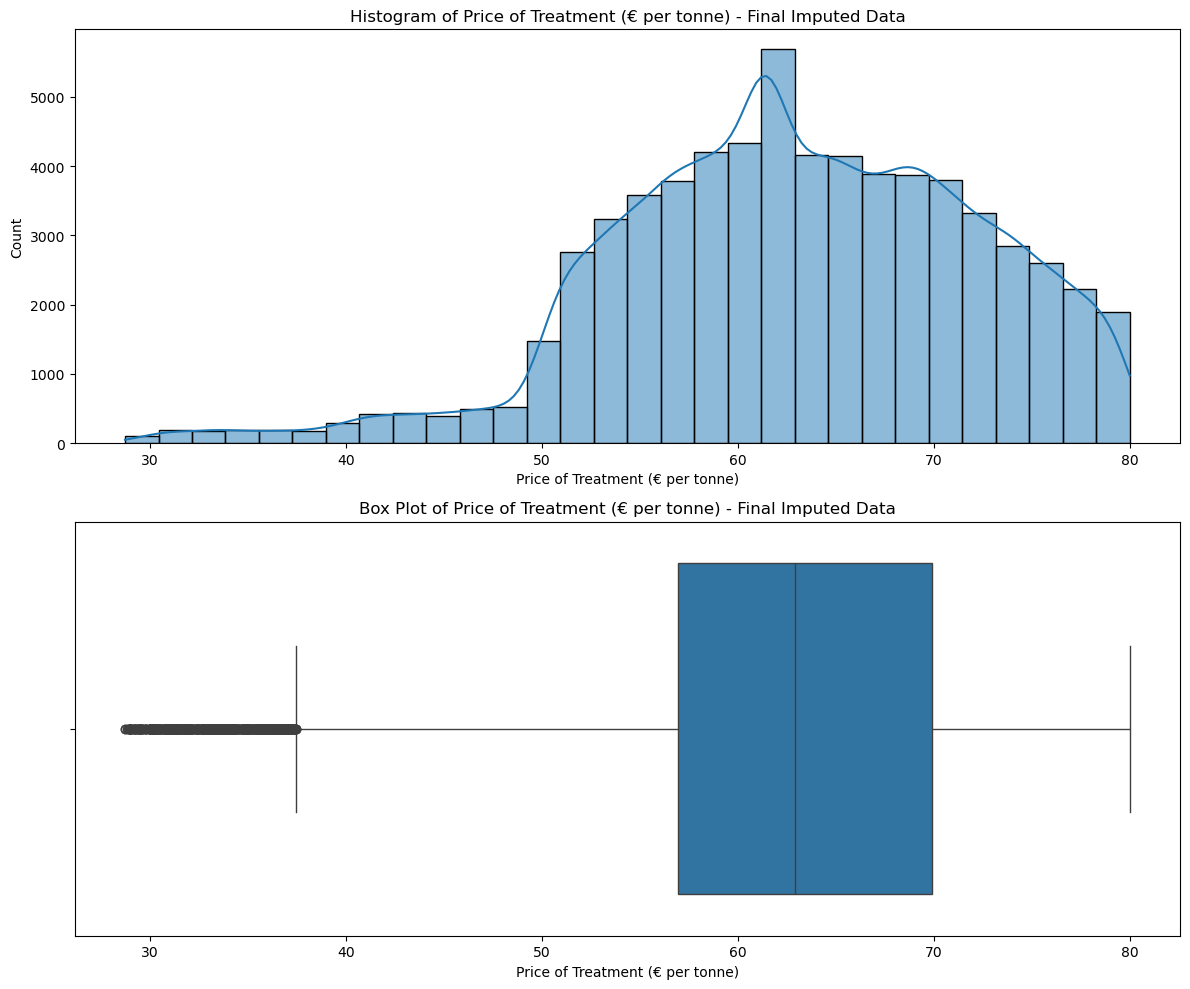


Final Dataset Shape: (65430, 8)

Final Missing Values:
Quarter                             0
County                              0
Waste Type                          0
Waste Category                      0
Treatment Method                    0
Waste Amount (tonnes)               0
Price of Treatment (€ per tonne)    0
Total Cost of Treatment             0
dtype: int64


In [545]:
for col in numerical_columns:
    plot_stats(data, col, "Final Imputed Data")

print("\nFinal Dataset Shape:", data.shape)
print("\nFinal Missing Values:")
print(data.isnull().sum())

# Decode categorical values if necessary
data[categorical_columns] = encoder.inverse_transform(data[categorical_columns])

#### Adds a new column for the average price of treatment by waste category and plots the statistics for this new column after imputation.


Final Imputed Data - Analysis for Average Price of Treatment by Waste Category (€ per tonne)

Basic Statistics:
+-----------+--------------------+
| Statistic |       Value        |
+-----------+--------------------+
|   count   |      65430.0       |
|   mean    | 62.94085083295125  |
|    std    | 1.6531760304633725 |
|    min    |       59.78        |
|    25%    |       62.23        |
|    50%    |       63.87        |
|    75%    |       64.33        |
|    max    |        64.6        |
+-----------+--------------------+

Additional Statistics:
| Metric         |   Value |
|:---------------|--------:|
| Missing Values |    0    |
| Skewness       |   -0.77 |
| Kurtosis       |   -0.8  |


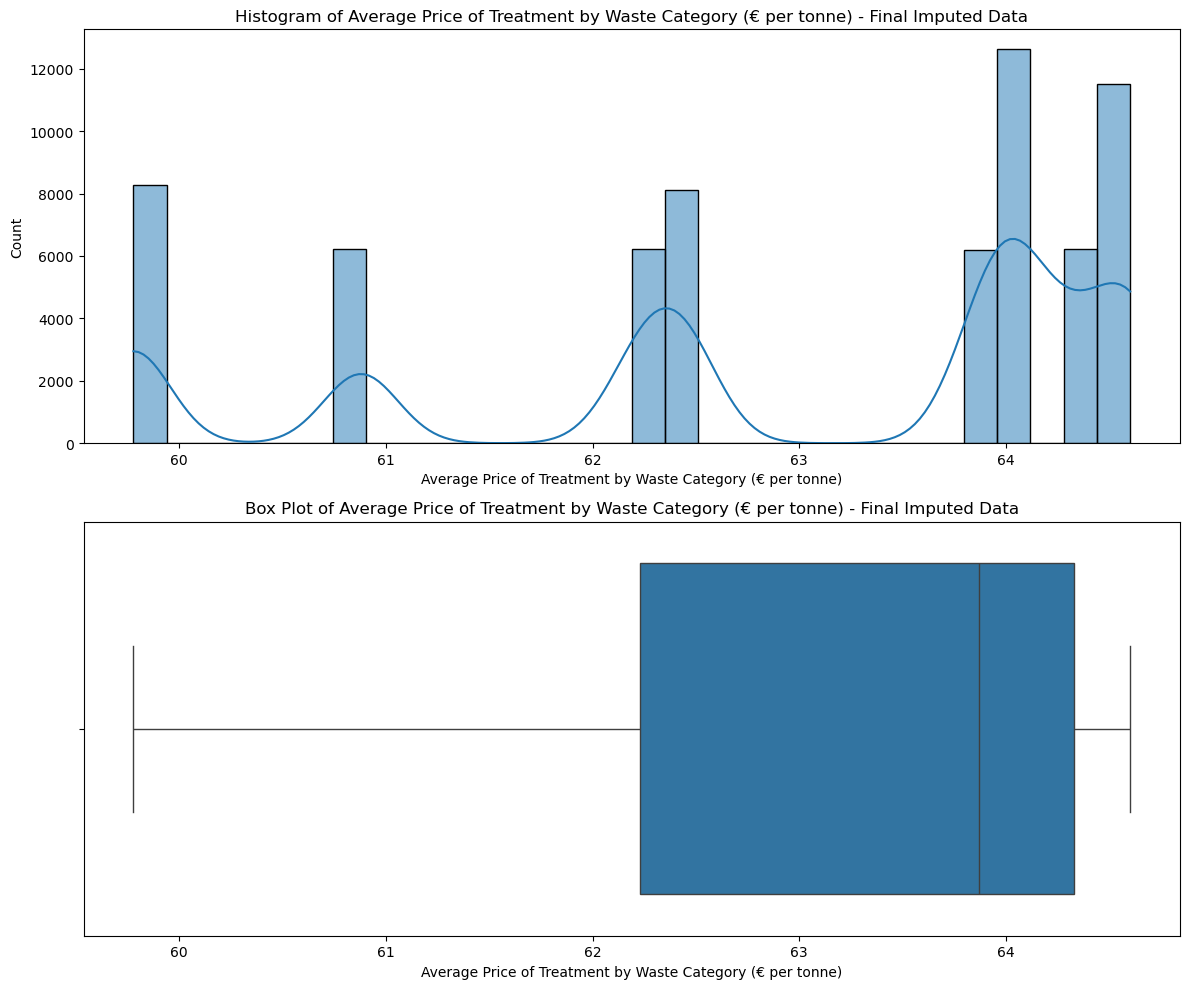

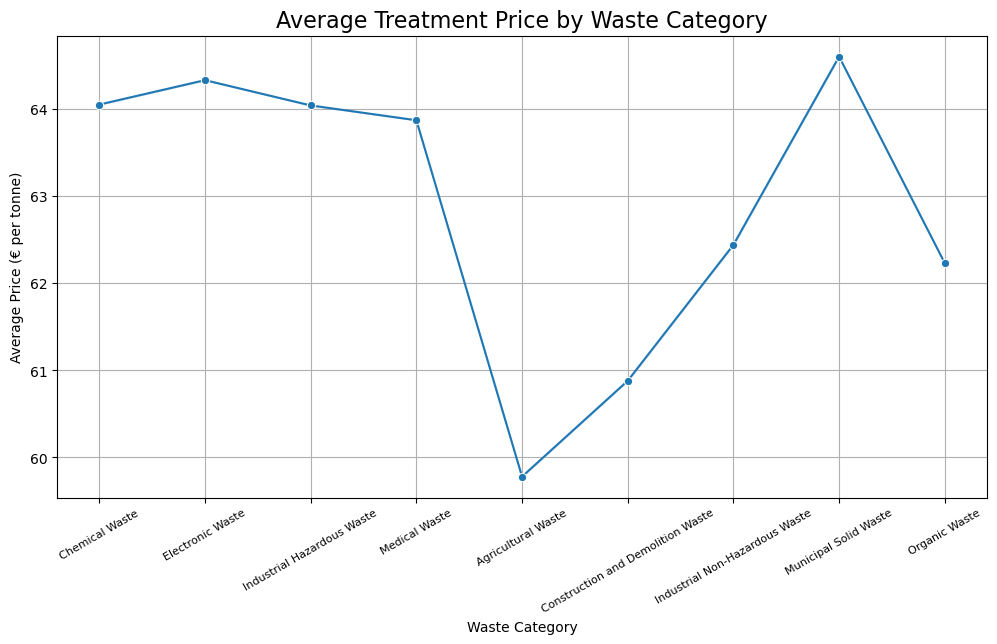

In [547]:
data['Average Price of Treatment by Waste Category (€ per tonne)'] = data.groupby('Waste Category')[
    'Price of Treatment (€ per tonne)'
].transform('mean').round(2)

# Plot stats for the new column
plot_stats(data, 'Average Price of Treatment by Waste Category (€ per tonne)', "Final Imputed Data")

plt.figure(figsize=(12, 6)) # making the graph wider
sns.lineplot(data=data, x='Waste Category', y='Average Price of Treatment by Waste Category (€ per tonne)', marker='o')
plt.title('Average Treatment Price by Waste Category', fontsize=16)
plt.xlabel('Waste Category')
plt.ylabel('Average Price (€ per tonne)')
plt.xticks(fontsize=8, rotation=30)
plt.grid(True)
plt.show()

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights from 'Average Treatment Price by Waste Category' (Calculated Field):
</div>


1. Price Variation: Treatment prices fluctuate across waste categories, with Organic Waste showing a sharp increase, while Chemical Waste and Electronic Waste remain stable.
2. Peak in Organic Waste: Organic Waste treatment costs are significantly higher compared to other categories, indicating possibly more complex or expensive processing.
3. Consistent Prices for Chemical and Electronic Waste: These categories exhibit stable treatment costs, reflecting consistent handling and treatment methods.
4. Fluctuations in Other Categories: Prices for Agricultural Waste and Medical Waste show some variation, possibly influenced by seasonal or operational factors.

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Key Focus Areas for Investigation:
</div>

1. Investigate the high treatment costs for Organic Waste.
2. Explore the stability of prices in Chemical and Electronic Waste.
3. Analyze the factors behind fluctuations in Agricultural and Medical Waste costs.

#### Save processed data

In [554]:
data.to_csv('imputed_data_final.csv', index=False)

#### Perform outlier analysis on Total Cost of Treatment

In [558]:
outlier_insights = detailed_outlier_analysis(total_cost_by_quarter, 'Total Cost of Treatment')

#### Prints detailed outlier analysis, including statistical boundaries, outlier details (such as total cost, difference from upper bound, and percentile rank), and the context of outliers (like mean, median, and percentage of outliers).

In [560]:
# Print detailed outlier insights
print("\n===== Detailed Outlier Analysis =====")
print("\nStatistical Boundaries:")
boundaries = outlier_insights['statistical_summary']
for key, value in boundaries.items():
    print(f"{key.replace('_', ' ').title()}: €{value:,.2f}")
 
print("\nOutlier Details:")
for outlier in outlier_insights['outlier_details']:
    print("\nQuarter: {}".format(outlier['Quarter']))
    print("Total Cost: €{:,.2f}".format(outlier['Total_Cost']))
    print("Difference from Upper Bound: €{:,.2f}".format(outlier['Difference_from_upper_bound']))
    print("Percentile Rank: {:.2f}%".format(outlier['Percentile']))
 
print("\nOutlier Context:")
context = outlier_insights['outlier_context']
for key, value in context.items():
    if key.endswith('percentage'):
        print(f"{key.replace('_', ' ').title()}: {value:.2f}%")
    elif key.endswith(('value', 'mean', 'median')):
        print(f"{key.replace('_', ' ').title()}: €{value:,.2f}")
    else:
        print(f"{key.replace('_', ' ').title()}: {value}")


===== Detailed Outlier Analysis =====

Statistical Boundaries:
Q1: €294,918,634.18
Q3: €387,872,035.23
Iqr: €92,953,401.05
Lower Bound: €155,488,532.61
Upper Bound: €527,302,136.80

Outlier Details:

Quarter: 0.0
Total Cost: €782,260,865.36
Difference from Upper Bound: €254,958,728.56
Percentile Rank: 16.89%

Quarter: 4.0
Total Cost: €799,791,280.28
Difference from Upper Bound: €272,489,143.48
Percentile Rank: 17.27%

Quarter: 8.0
Total Cost: €602,424,290.70
Difference from Upper Bound: €75,122,153.90
Percentile Rank: 13.01%

Quarter: 12.0
Total Cost: €605,888,135.42
Difference from Upper Bound: €78,585,998.62
Percentile Rank: 13.08%

Quarter: 16.0
Total Cost: €4,631,290,317.38
Difference from Upper Bound: €4,103,988,180.58
Percentile Rank: 100.00%

Quarter: 20.0
Total Cost: €611,792,682.53
Difference from Upper Bound: €84,490,545.73
Percentile Rank: 13.21%

Quarter: 24.0
Total Cost: €796,460,896.51
Difference from Upper Bound: €269,158,759.71
Percentile Rank: 17.20%

Quarter: 28.0
To

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights from Outlier Analysis Of 'Total Cost of Treatment By Quarter' (Calculated Field):
</div>

 1. High Concentration of Outliers in Q1: All outliers occur in the first quarter of various years, suggesting a consistent seasonal or operational anomaly driving elevated costs during Q1.
 2. Extreme Outlier in 2008_Q1: The total cost for Q1 2008 (€4.4 billion) is an extreme anomaly, 10 times higher than the IQR upper bound and vastly exceeding other outliers. This data point significantly impacts the overall distribution.
 3. Distribution of Outliers:
    • Outliers are spread across most years, with recurring costs exceeding the upper bound by €65M–€284M.
    • 25% of quarters fall outside the statistical norm, indicating systemic factors rather than isolated incidents.
 4.	Skewed Distribution: The mean (€440M) is significantly higher than the median (€307M) due to the 2008_Q1 outlier, highlighting its disproportionate effect on central tendency.
 5.	Consistency in High-Cost Years: Several years, such as 2005, 2010, 2011, 2013, 2019, and 2023, show repeated costs far above the upper bound, with percentile ranks near 18%, indicating sustained high spending trends in Q1.
 6.	Potential Factors: The consistent pattern suggests underlying trends like increased demand, reporting issues, or high seasonal expenses driving Q1 spikes.

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Key Focus Areas for Investigation:
</div>

 - Examine the drivers behind Q1 trends, particularly in 2008.
 - Identify operational or external factors (e.g., policy, economic events) influencing seasonal cost spikes.
 - Re-evaluate data collection or reporting methods for Q1 to rule out systemic issues.

<br></br>
<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Contribution Statement:
</div>

**Group Member Contributions**:  
- **Parth Dabhekar**: Led data cleaning and processing, handled missing values, performed exploratory data analysis (EDA) to identify trends and outliers, and contributed to markdown reports with detailed documentation.
- **Vaishnavi Deshmukh**: Focused on addressing missing values, conducted in-depth exploratory data analysis (EDA), managed data processing, created compelling visualizations, and contributed to the final report.
- **Omkar Phadtare**: Engaged in data cleaning and standardization, derived actionable insights, conducted EDA, formulated conclusions, and contributed to markdown reports with structured outputs.
- **Weixi Wang**: EDA, Report writing, Referencing
- **Sourajit Ghatak**: Handling outliers, Creating calculated fields, Report writing

<br></br>
<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Individual Reflections:
</div>

- **Parth Dabhekar**:  
    - **Most enjoyable part**: Discovering how Python libraries like Pandas and Matplotlib simplify complex data analysis.  
    - **Most challenging aspect**: Debugging errors in data preprocessing due to inconsistent formats in the datasets.  
    - **Most valuable thing learned**: The importance of structuring code for reusability and collaboration in team projects.

- **Vaishnavi Deshmukh**:  
    - **Most enjoyable part**: Designing reusable Python functions that made data cleaning efficient and scalable.  
    - **Most challenging aspect**: Merging datasets while preserving data integrity and avoiding duplication.  
    - **Most valuable thing learned**: Leveraging Python to transition raw data into meaningful insights that drive informed decisions.

- **Omkar Phadtare**:  
    - **Most enjoyable part**: Extracting actionable insights from the data and crafting meaningful conclusions from the EDA.  
    - **Most challenging aspect**: Standardizing datasets to ensure compatibility without losing critical information, especially when using Random Forest for modeling.  
    - **Most valuable thing learned**: How crucial fine-tuning hyperparameters like `n_estimators`, `max_depth`, and `n_jobs` was to improve the model’s accuracy and generalization, reducing overfitting and enhancing overall performance.

- **Weixi Wang**:  
    - **Most enjoyable part**: Gaining more knowledge from a variety of aspects (e.g., multiple codes, handling approaches, and more treatment logic).  
    - **Most challenging aspect**: Cleaning data for missing values and mastering the treatment method.  
    - **Most valuable thing learned**: Appreciating everyone's work methods and learning how to summarize and extract the essence of approaches from each other.

- **Sourajit Ghatak**:  
    - **Most enjoyable part**: Finding trends with the help of visualizations.  
    - **Most challenging aspect**: Inconsistent data and data quality can heavily affect data analysis.  
    - **Most valuable thing learned**: The importance of data cleaning and processing before analysis.

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    References:
</div>
   
- wearemci. (2024). Navigating the data analytics lifecycle: a comprehensive guide, Retrieved on 25 11, 2024, from https://www.wearemci.com/en/thoughts/data-analytics-lifecycle#:~:text=Essentially%2C%20the%20data%20analytics%20lifecycle,insights%20you're%20aiming%20for
-  geeksforgeeks.( 2024, 08 12). Interquartile Range to Detect Outliers in Data, Retrieved on 25 11, 2024, from 
https://www.geeksforgeeks.org/interquartile-range-to-detect-outliers-in-data
- IBM (2024). What is exploratory data analysis (EDA)?, Retrieved on 25 11, 2024, from https://www.ibm.com/topics/exploratory-data-analysis#:~:text=Exploratory%20data%20analysis%20(EDA)%20is,often%20employing%20data%20visualization%20methods